# Value and Momentum

In this section I present the results of the univariate regressions of Value and Momentum.
We define Value as the Book to Market raio, Book Equity / Market Equity for a firm at time t.
Momentum is the preceding annual return from t-13 to t-1 months. We lag by one month to account for mean reverting behaviour in the short-term.

In [24]:
import warnings
import pandas as pd
import statsmodels.api as sm
from utils import *
from statsmodels.api import OLS
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
df = pd.read_parquet('data/market_data.parquet')
df['date'] = pd.to_datetime(df['jdate'])
df['me_rank'] = df.groupby('date')['me'].rank(ascending=False)

Our dataset from CRSP/Compustat provides us with cumulative returns which we can transform to get our momentum factor.
We also create our regression target, the forward 1 year returns.

In [26]:
df['ann_ret_shifted'] = df.groupby('permno')['cumretx'].shift(-12)
df['ann_ret'] = df['ann_ret_shifted'] / df['cumretx'] - 1

df['momentum_shifted'] = df.groupby('permno')['cumretx'].shift(1)
df['momentum'] = df['momentum_shifted'] / df.groupby('permno')['cumretx'].shift(13) - 1
df = df.drop(columns=['ann_ret_shifted', 'momentum_shifted'])

We drop all firms which are outside of the top 600, this should give us the SP500 as well as firms that are near being listed/delisted.

In [27]:
df = df[df['me_rank'].shift(1) < 600]

Our data is now ready for rolling regression analysis. We take a rolling regression to account for regime changes as well as to get the stability of our coefficients over time. We make sure they're temporally robust by forcing the rolling regression using a loop and indexing accordingly. We keep a 5 year lookback period so we have sufficient data for a fit.

In [28]:
beme_df = df[['date', 'permno', 'beme', 'ann_ret']]
counter = 0
number_of_firms = len(beme_df['permno'].unique())
for firm in beme_df['permno'].unique():
    counter += 1
    print(f'Processing firm {counter / number_of_firms * 100:.2f}%', end='\r')
    subset = beme_df[beme_df['permno'] == firm].sort_values('date').dropna(subset=['beme', 'ann_ret']).reset_index()
    for i in range(12 * 5 + 1, len(subset)):
        X = subset.loc[i - 12 * 5:i - 1, 'beme']
        X = sm.add_constant(X)
        y = subset.loc[i - 12 * 5:i - 1, 'ann_ret']
        
        model = sm.OLS(y, X).fit()
        
        # Assign the alpha and beta values to beme_df, ensuring proper indexing by both permno and date
        beme_df.loc[(beme_df['permno'] == firm) & (beme_df['date'] == subset.iloc[i]['date']), 'beme_alpha'] = model.params[0]
        beme_df.loc[(beme_df['permno'] == firm) & (beme_df['date'] == subset.iloc[i]['date']), 'beme_beta'] = model.params[1]

We lag our coefficients by a year to avoid any forward-looking bias when testing the predictions out of sample.

In [29]:
beme_df['beme_beta'] = beme_df.groupby('permno')['beme_beta'].shift(12)
beme_df['beme_alpha'] = beme_df.groupby('permno')['beme_alpha'].shift(12)
beme_df['predict'] = beme_df['beme_alpha'] + beme_df['beme_beta'] * beme_df['beme']

We take crossectional mean coefficients, this is not a perfect measure for the relationship, but works as a proxy to visually assess the stbaility of the value relationship over time. Decays in relationships can be seen in flattening trend lines, and reversals of the relationship can be seen in a change in trend.

<Axes: xlabel='date'>

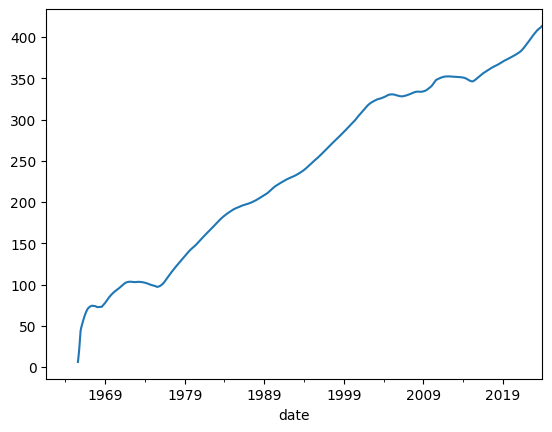

In [30]:
x = beme_df.groupby('date')['beme_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

Plotting actual vs predicted shows us the suitability of our fit. We see a weak and non-monotonic fit. Additionally, to note is that these are bucketed plots, and the true relationship is even noisier.

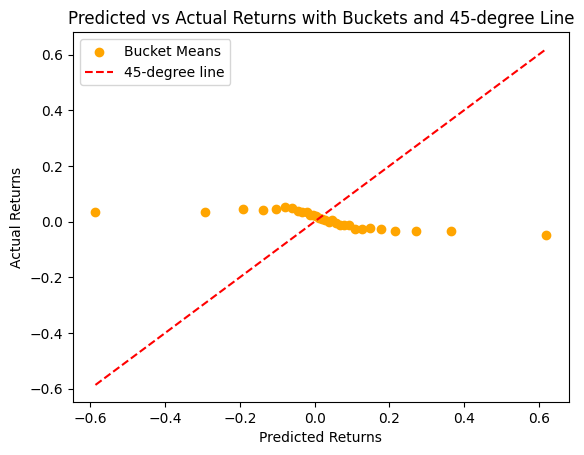

In [31]:
plot_actual_vs_predicted(beme_df, 'predict', 'ann_ret')

Plotting the residuals, we see the shortfalls of our linear fit. The relationship is clearly non-linear, and breaks down for more extreme values for value. I can approach this by windsorizing the data at tails but, I leave it as is for the purpose of this task. Using a non-linear model, a small neural net or a polynomial regression could help with a superior fit.

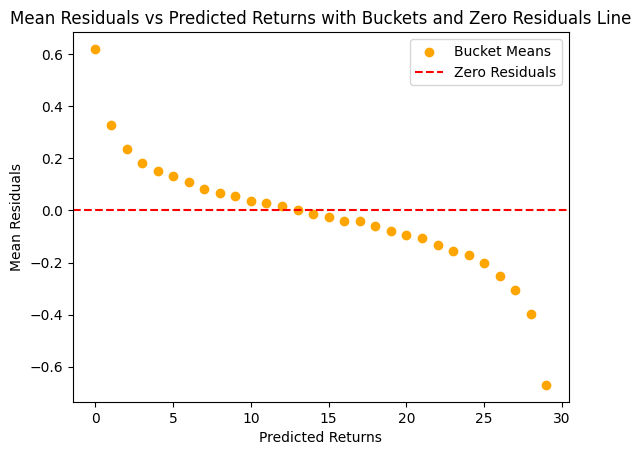

In [32]:
plot_residuals(beme_df, 'predict', 'ann_ret')

These same steps can be repeated for the Momentum case.

In [33]:
momentum_df = df[['date', 'permno', 'momentum', 'ann_ret']]
counter = 0
number_of_firms = len(momentum_df['permno'].unique())
for firm in momentum_df['permno'].unique():
    counter += 1
    print(f'Processing firm {counter / number_of_firms * 100:.2f}%', end='\r')
    subset = momentum_df[momentum_df['permno'] == firm].sort_values('date').dropna(subset=['momentum', 'ann_ret']).reset_index()
    for i in range(12 * 5 + 1, len(subset)):
        X = subset.loc[i - 12 * 5:i - 1, 'momentum']
        X = sm.add_constant(X)
        y = subset.loc[i - 12 * 5:i - 1, 'ann_ret']
        
        model = sm.OLS(y, X).fit()
        
        # Assign the alpha and beta values to beme_df, ensuring proper indexing by both permno and date
        momentum_df.loc[(momentum_df['permno'] == firm) & (momentum_df['date'] == subset.iloc[i]['date']), 'momentum_alpha'] = model.params[0]
        momentum_df.loc[(momentum_df['permno'] == firm) & (momentum_df['date'] == subset.iloc[i]['date']), 'momentum_beta'] = model.params[1]
momentum_df.head()

,date,permno,momentum,ann_ret,momentum_alpha,momentum_beta
985,1964-08-31,10006,NaN,-0.019139,NaN,NaN
986,1964-09-30,10006,NaN,-0.098498,NaN,NaN
987,1964-10-31,10006,NaN,-0.029525,NaN,NaN
988,1964-11-30,10006,NaN,-0.017443,NaN,NaN
989,1964-12-31,10006,NaN,0.121360,NaN,NaN


Lagging the coefficients to avoid forward-looking bias in the coefficients.

In [34]:
momentum_df['momentum_beta'] = momentum_df.groupby('permno')['momentum_beta'].shift(12)
momentum_df['momentum_alpha'] = momentum_df.groupby('permno')['momentum_alpha'].shift(12)
momentum_df['predict'] = momentum_df['momentum_alpha'] + momentum_df['momentum_beta'] * momentum_df['momentum']
momentum_df.head()

,date,permno,momentum,ann_ret,momentum_alpha,momentum_beta,predict
985,1964-08-31,10006,NaN,-0.019139,NaN,NaN,NaN
986,1964-09-30,10006,NaN,-0.098498,NaN,NaN,NaN
987,1964-10-31,10006,NaN,-0.029525,NaN,NaN,NaN
988,1964-11-30,10006,NaN,-0.017443,NaN,NaN,NaN
989,1964-12-31,10006,NaN,0.121360,NaN,NaN,NaN


We find a stable relationship

<Axes: xlabel='date'>

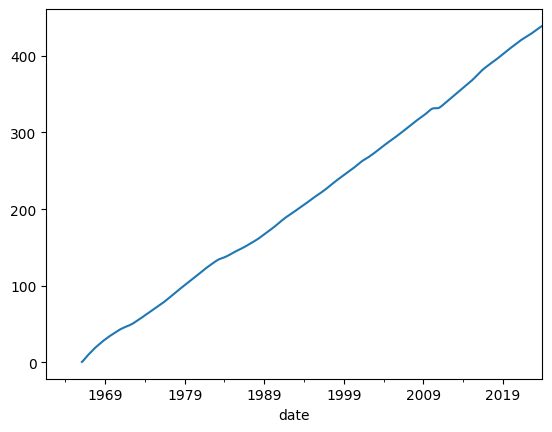

In [35]:
x = momentum_df.groupby('date')['momentum_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

We find good monotonicity and a linear relationship. The Aactual vs predicted as well as the residual plots both show the break-down of the linear relationship beyond a threshold, and windsorization or a non-linear fit would be reasonable approaches to further improving the univariate model.

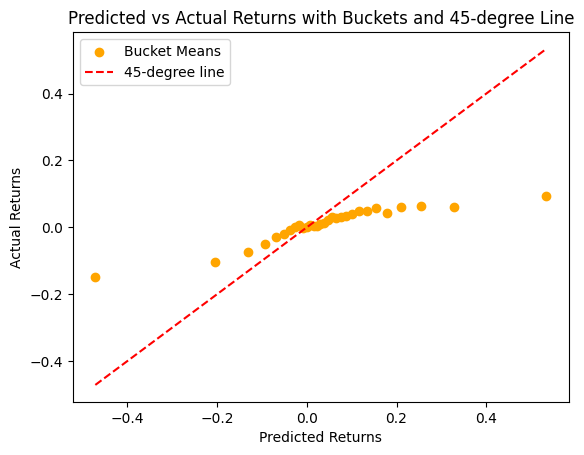

In [36]:
plot_actual_vs_predicted(momentum_df, 'predict', 'ann_ret')

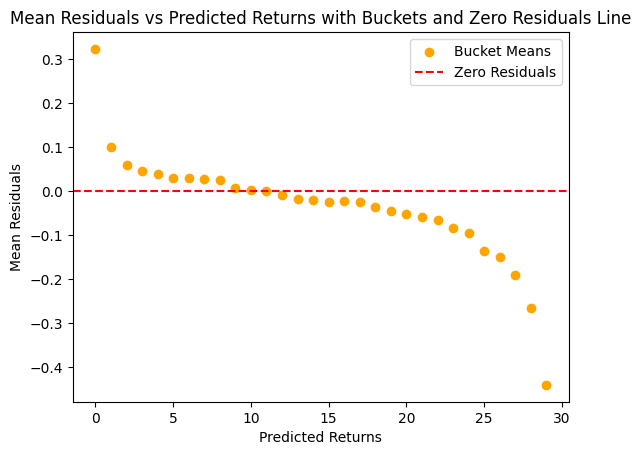

In [37]:
plot_residuals(momentum_df, 'predict', 'ann_ret')